In [109]:
import netket as nk
import jax
from netket.operator.spin import sigmax,sigmaz
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
import time

def ABC(L, a):
    B = {}
    A = {a}
    C = {}
    for i in range (a+1, L-1):
        B[i] = [i]
    for i in B:
        if i!=a+1:
            B[i]+=B[i-1]
            B[i].sort()
    for i in B:
        C[i] = set(range(L))-set(B[i])-A
    return A, B, C

def ABC_periodic(L):
    B = {}
    A = {}
    C = {}
    for i in range (int(L/2)):
        A[i] = [i]
        C[i] = [i+int(L/2)]

    for i in A:
        if i!=0:
            A[i]+=A[i-1]
            C[i]+=C[i-1]
            A[i].sort()
            C[i].sort()
        B[i] = list(set(range(L))-set(A[i])-set(C[i]))
    return A, B, C

def cmi_(prob_exact, L):
    A,B,C = ABC(L, 0)
    cmi = []
    p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
    p_bc = prob_exact.sum(axis=tuple(A))+1e-30
    cmi.append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact*np.log(prob_exact+1e-30)))
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        p_b = prob_exact.sum(axis=tuple(C[i].union(A)))+1e-30
        tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return np.array(cmi)

def cmi_periodic(prob_exact, L):
    A,B,C = ABC_periodic(L)
    cmi = []
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A[i]))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        if i != int(L/2)-1:
            p_b = prob_exact.sum(axis=tuple(list(set(C[i]).union(set(A[i])))))+1e-30
            tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return cmi

def cmi_traceout(prob_exact, L):
    I = []
    cmi = [[] for i in range(L-5)]
    for i in range(L-5):
        if i!=0:
            I.append(i)
        A,B,C = ABC(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))+1e-30
        prob_exact_ = prob_exact.sum(axis=tuple(set(I)))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact_*np.log(prob_exact_+1e-30)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(C[j].union(set(I))))
            tmp += np.sum(p_ab*np.log(p_ab))
            p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))
            tmp += np.sum(p_bc*np.log(p_bc))
            tmp -= np.sum(prob_exact_*np.log(prob_exact_+1e-30))
            p_b = prob_exact.sum(axis=tuple(C[j].union(A).union(set(I))))
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)
    return np.array(cmi)

def cmi_traceout_periodic(prob_exact, L):
    I = []
    cmi = [[] for i in range(L-5)]
    for i in range(L-5):
        if i!=0:
            I.append(i)
        A,B,C = ABC(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))+1e-30
        prob_exact_ = prob_exact.sum(axis=tuple(set(I)))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact_*np.log(prob_exact_+1e-30)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(C[j].union(set(I))))
            tmp += np.sum(p_ab*np.log(p_ab))
            p_bc = prob_exact.sum(axis=tuple(A.union(set(I))))
            tmp += np.sum(p_bc*np.log(p_bc))
            tmp -= np.sum(prob_exact_*np.log(prob_exact_+1e-30))
            p_b = prob_exact.sum(axis=tuple(C[j].union(A).union(set(I))))
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)
    return np.array(cmi)

def spin_correlation_all(prob_exact, L):
    corr = [[] for i in range(L)]
    mean_corr = [[] for i in range(L)]
    var_corr = [[] for i in range(L)]
    for i in range(L):
        for j in range(i+1, L):
            p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([i, j])))+1e-30
            p_spin0 = p_spin.sum(axis=0)
            p_spin1 = p_spin.sum(axis=1)
            cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
            corr[np.abs(j-i)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([i])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.array(mean_corr), np.array(var_corr)

def spin_correlation_periodic(prob_exact, L):
    corr = [[] for i in range(int(L/2)+1)]
    mean_corr = [[] for i in range(int(L/2)+1)]

    for i in range(1, int(L/2)+1):
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([0, i])))+1e-30
        p_spin0 = p_spin.sum(axis=0)
        p_spin1 = p_spin.sum(axis=1)
        cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
        corr[np.abs(i)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L))-set([0])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
    return np.array(mean_corr)
def count_diff_ones_zeros(n):
    # Generating all combinations from 0^n to 1^n
    combinations = np.array([np.binary_repr(i, width=n) for i in range(2**n)])

    # Counting the difference between the number of 1s and 0s in each combination
    diff_counts = np.array([combination.count('1') - combination.count('0') for combination in combinations])

    return diff_counts
L = 16
hi = nk.hilbert.Spin(s=1 / 2, N=L)
Gamma = -1
B = [-0.5, -0.8, -0.95, -1.0, -1.05, -1.2, -1.5, -2.0, -3.5, -6.0]
periodic = False
for B_field in B:
    H = sum([B_field*sigmax(hi,i) for i in range(L)])
    H += sum([Gamma*sigmaz(hi,i)*sigmaz(hi,(i+1)) for i in range(L-1)])
    if periodic:
        H += Gamma*sigmaz(hi,0)*sigmaz(hi,L-1)
    sp_h = H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
    print("eigenvalues with scipy sparse:", eig_vals)
    probs_exact =  np.abs(eig_vecs[:, 0]) ** 2
    if B_field == 0.0:
        print(np.flip(np.sort(probs_exact)))
    mag = np.sum(probs_exact*np.array(count_diff_ones_zeros(L)))
    shape = (2,) * (L)
    probs_exact = probs_exact.reshape(*shape)

    if (periodic == False):
        cmi = cmi_(probs_exact, L)
        mean_corr, var_corr = spin_correlation_all(probs_exact, L)

    else:
        cmi = cmi_periodic(probs_exact, L)
        mean_corr = spin_correlation_periodic(probs_exact, L)
    cmi_all = cmi_traceout(probs_exact, L)
    np.save("result/1DTFIM/cmi_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", cmi)
    np.save("result/1DTFIM/mean_corr_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", mean_corr)
    if periodic == False:
        np.save("result/1DTFIM/var_corr_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", var_corr)
    np.save("result/1DTFIM/cmi_traceout_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", cmi_all)
    np.save("result/1DTFIM/mag_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", mag)
    np.save("result/1DTFIM/gap_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".npy", np.array(eig_vals[1]-eig_vals[0]))


eigenvalues with scipy sparse: [-16.14605096 -16.14602807]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25444\2058354607.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cmi)


eigenvalues with scipy sparse: [-18.04987643 -18.02952713]
eigenvalues with scipy sparse: [-19.46823411 -19.34075463]
eigenvalues with scipy sparse: [-20.0163879  -19.82606024]
eigenvalues with scipy sparse: [-20.59482511 -20.33177253]
eigenvalues with scipy sparse: [-22.46499827 -21.94919197]
eigenvalues with scipy sparse: [-26.56681187 -25.4870656 ]
eigenvalues with scipy sparse: [-33.90185203 -31.84178623]
eigenvalues with scipy sparse: [-57.0762502  -52.03091305]
eigenvalues with scipy sparse: [-96.62594597 -86.5860944 ]


In [104]:
import numpy as np
import matplotlib.pyplot as plt
# Dictionary to store the loaded arrays
L = 16
periodic = True

cmi = {}
mean_corr= {}
var_corr = {}
gap = {}
cmi_traceout = {}
mag = {}
# Looping through the values and loading each file
for b in B:
    filename = f"result/1DTFIM/cmi_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    cmi[b] = np.load(filename)
    if periodic == True:
        cmi[b] = np.flip(cmi[b])
    filename = f"result/1DTFIM/mean_corr_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    mean_corr[b] = np.load(filename)
    if periodic == False:
        filename = f"result/1DTFIM/var_corr_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
        var_corr[b] = np.load(filename)
    filename = f"result/1DTFIM/gap_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    gap[b] = np.load(filename)
    filename = f"result/1DTFIM/cmi_traceout_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    cmi_traceout[b] = np.load(filename, allow_pickle=True)
    filename = f"result/1DTFIM/mag_1DTFIM_L{L}_B_{b}periodic_{periodic}.npy"
    mag[b] = np.load(filename)


{0.0: array([        nan, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.62427689]),
 -0.2: array([3.66484620e-13, 2.08091322e-11, 7.96106736e-10, 2.96367383e-08,
        1.19615038e-06, 5.62056861e-05, 3.60276641e-03, 6.93164599e-01]),
 -0.5: array([6.41590168e-08, 1.09408858e-06, 9.48133770e-06, 6.49731527e-05,
        4.22397795e-04, 2.95914953e-03, 2.67765679e-02, 6.94521854e-01]),
 -0.8: array([1.20644423e-05, 1.32720981e-04, 6.70841871e-04, 2.47436817e-03,
        7.89509533e-03, 2.42751653e-02, 8.38719208e-02, 6.85269024e-01]),
 -0.9: array([2.62866187e-05, 2.69114532e-04, 1.25072685e-03, 4.18567485e-03,
        1.19616797e-02, 3.24146535e-02, 9.59875032e-02, 6.40480718e-01]),
 -0.95: array([3.01206636e-05, 3.00554210e-04, 1.35908507e-03, 4.41440671e-03,
        1.22181991e-02, 3.20146934e-02, 9.12569334e-02, 5.91319555e-01]),
 -1.0: array([2.83278258e-05, 2.77200646e-04, 1.23019669e-03, 3.92380957e-03,
        1.06814446e-02, 2.76419873

In [105]:
cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[] for i in range (len(B))]
err_cmi_length_traceout = [[] for i in range (len(B))]
for i in B:
    cmi[i] = np.abs(cmi[i])
    for j in range(len(cmi_traceout[i])):
        cmi_traceout[i][j] = np.abs(np.array(cmi_traceout[i][j]))
for i in B:
    df = len(cmi[i])-2
    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(cmi[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[i])) - mean_x)**2))
    cmi_length.append(cmi_len)
    err_cmi_length.append(err)

    (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[i])), -np.log(mean_corr[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(mean_corr[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[i])) - mean_x)**2))
    corre_length.append(corr_len)
    err_corre_length.append(err)

    for j in range(len(cmi_traceout[i])):
        df = len(cmi_traceout[i][j])-2
        (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[i][j])), -np.log(cmi_traceout[i][j]+1e-32), 1, full=True)
        mean_x = np.mean(np.arange(len(cmi_traceout[i][j])))
        err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[i][j])) - mean_x)**2))
        cmi_length_traceout[B.index(i)].append(cmi_len)
        err_cmi_length_traceout[B.index(i)].append(err)



C:\Users\Administrator\AppData\Local\Temp\ipykernel_25444\2126003938.py:13: RuntimeWarning: divide by zero encountered in log
  (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25444\478728045.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(cmi[i]), label="B="+str(i))


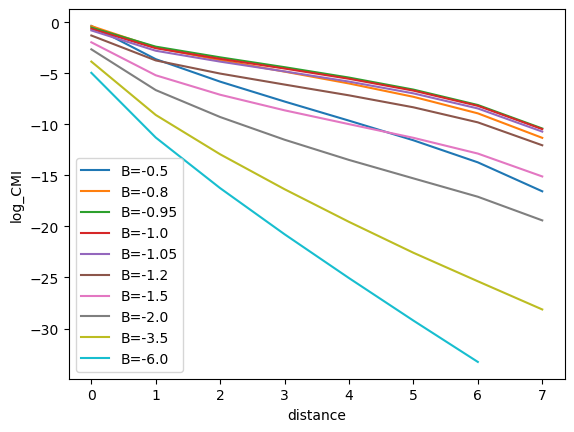

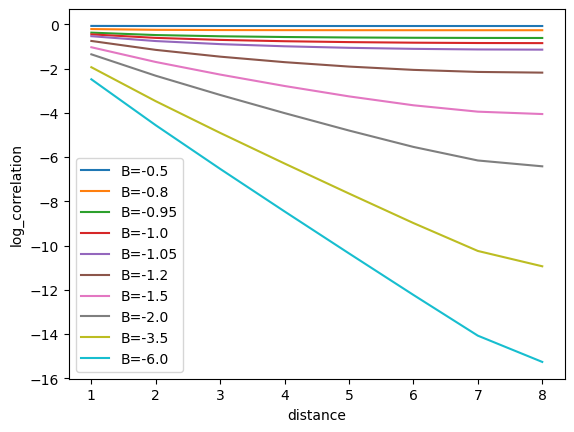

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


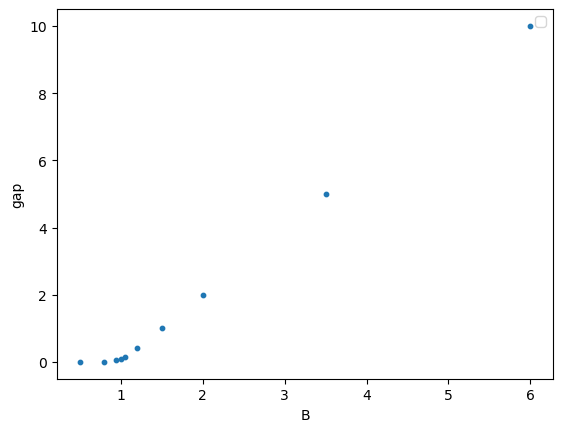

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25444\478728045.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(mean_corr[i][1:]), np.log(cmi[i]), label="B="+str(i))


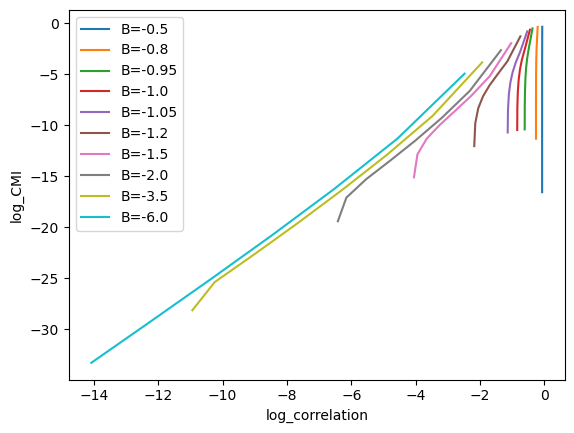

In [106]:
for i in B:
    plt.plot(np.log(cmi[i]), label="B="+str(i))
plt.xlabel("distance")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DTFIM/cmi_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in B:
    plt.plot(np.arange(len(mean_corr[i])-1)+1, np.log(mean_corr[i][1:]), label="B="+str(i))
    if periodic == False:
        plt.fill_between(np.arange(len(mean_corr[i])-1)+1 ,np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("distance")
plt.ylabel("log_correlation")
plt.legend()
plt.savefig("figure/1DTFIM/correlation_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

B_ = [-B[i] for i in range(len(B))]
plt.scatter(B_, gap.values(), s=10)
plt.xlabel("B")
plt.ylabel("gap")
plt.legend()
plt.savefig("figure/1DTFIM/gap_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in B:
    plt.plot(np.log(mean_corr[i][1:]), np.log(cmi[i]), label="B="+str(i))
    if periodic == False:
        plt.fill_betweenx(np.log(cmi[i]), np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("log_correlation")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DTFIM/correlation_cmi_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()


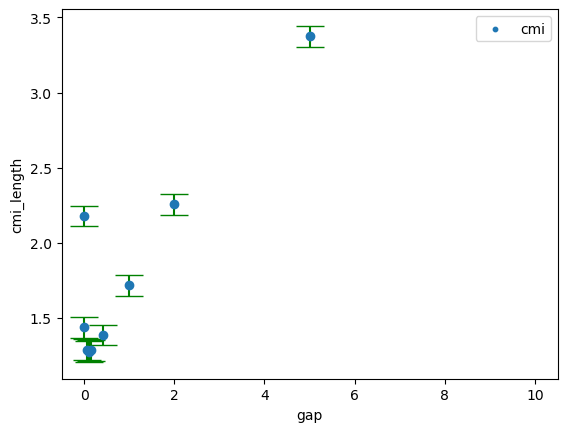

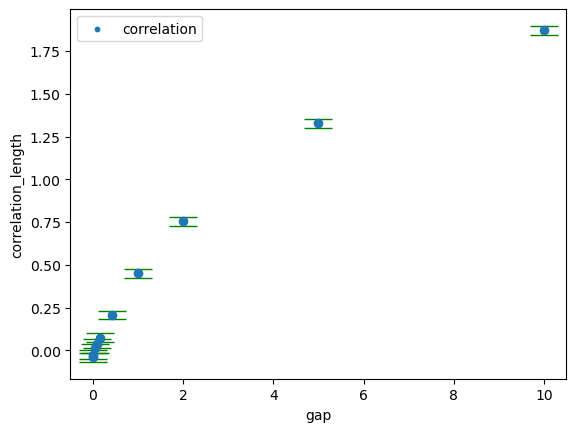

In [107]:
gap_list = []
for i in B:
    gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/1DTFIM/cmi_length_gap_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

plt.scatter(gap_list, corre_length, label="correlation", s=10)
plt.errorbar(gap_list, corre_length, yerr=err_corre_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/1DTFIM/correlation_length_gap_1DTFIM_L"+str(L)+"_B_"+str(B_field)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

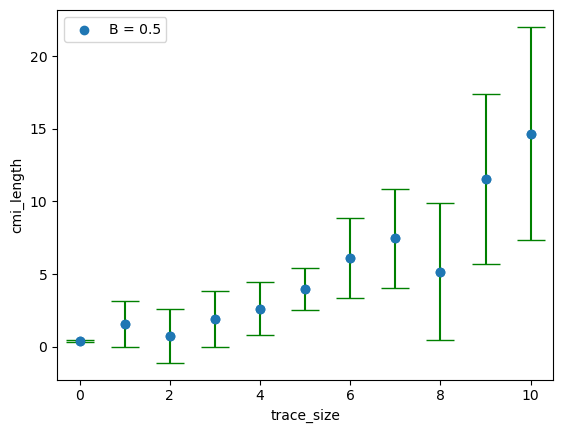

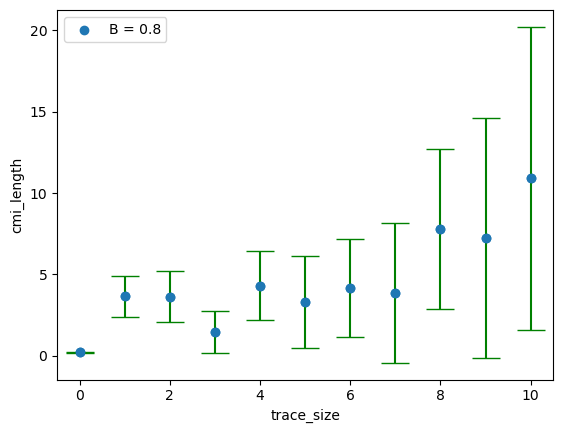

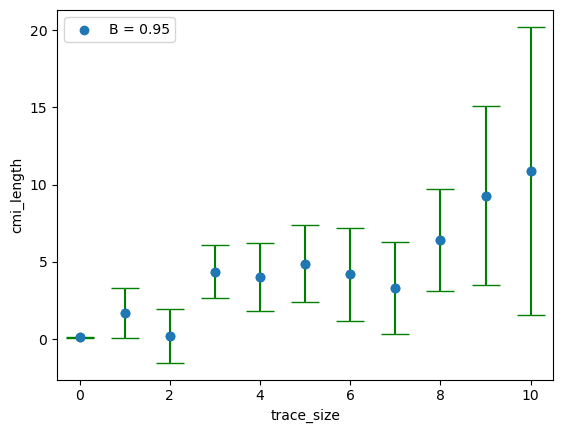

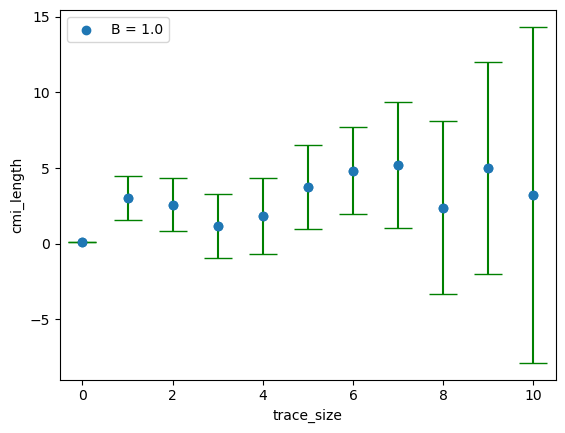

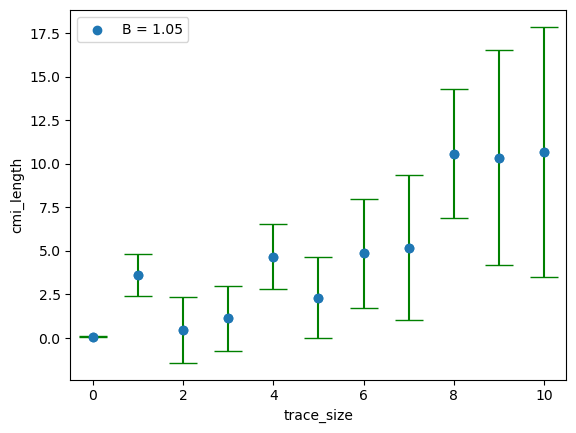

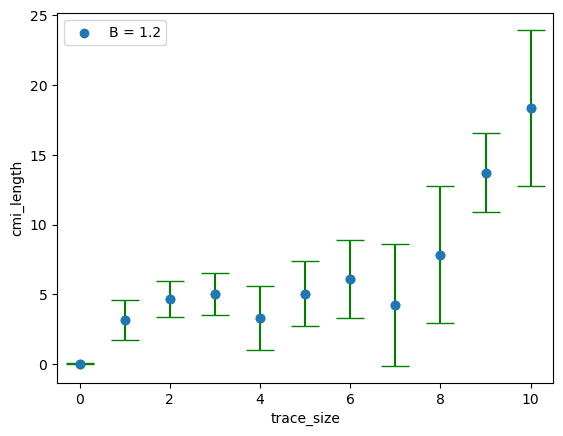

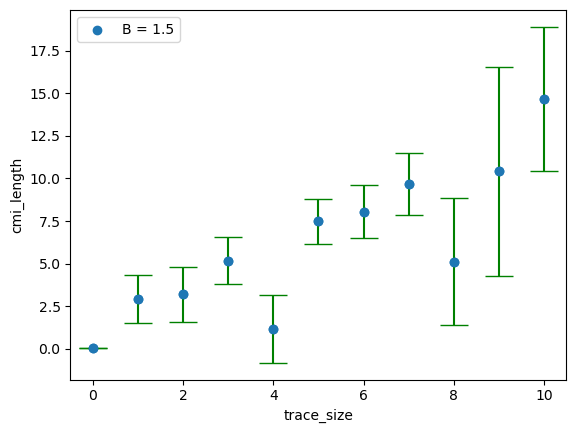

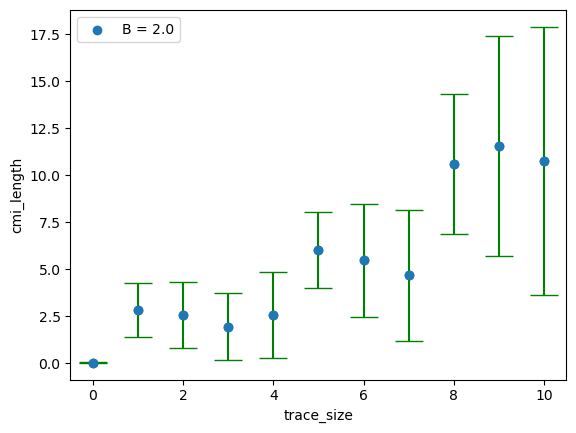

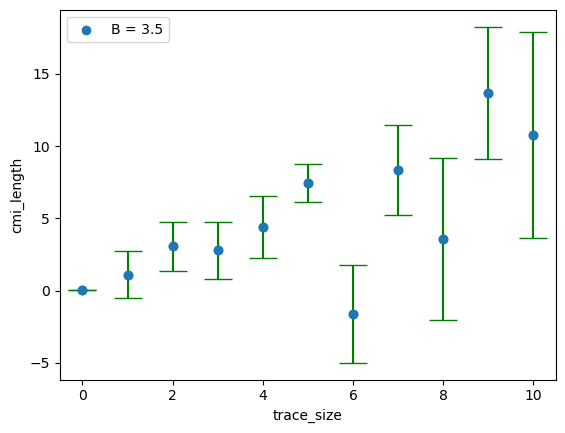

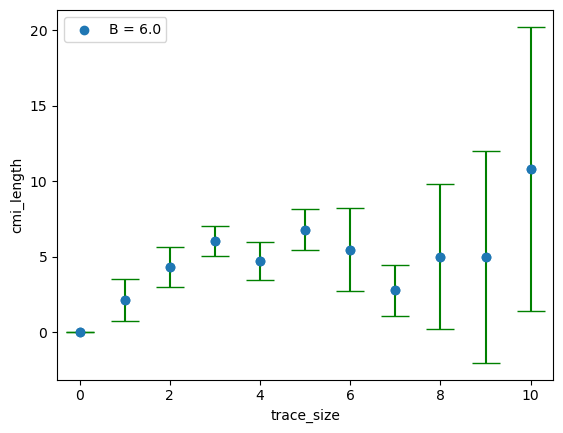

<Figure size 640x480 with 0 Axes>

In [108]:
for i in range(len(B_)):
    plt.scatter(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], label="B = "+str(B_[i]))
    plt.errorbar(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], yerr=np.array(err_cmi_length_traceout[i]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/1DTFIM/traceout/cmi_length_traceout_1DTFIM_L"+str(L)+"_B_"+str(B_[i])+"periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()

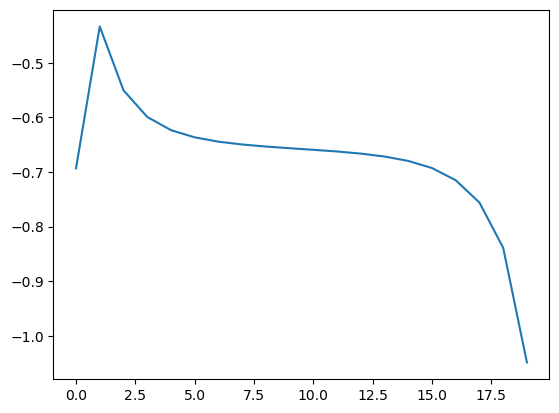

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29504\2379032831.py:7: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(spin5[1:]), np.log(cmi5),label="B=-3.0")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29504\2379032831.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(spin6[1:]), np.log(cmi6),label="B=-3.5")


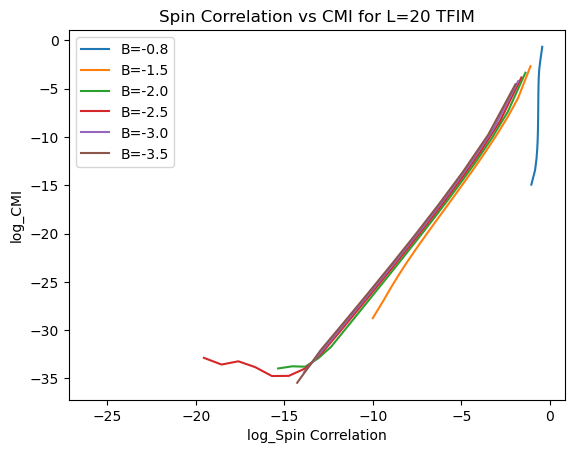

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.log(spin1[1:]), np.log(cmi1),label="B=-0.8")
plt.plot(np.log(spin2[1:]), np.log(cmi2),label="B=-1.5")
plt.plot(np.log(spin3[1:]), np.log(cmi3),label="B=-2.0")
plt.plot(np.log(spin4[1:]), np.log(cmi4),label="B=-2.5")
plt.plot(np.log(spin5[1:]), np.log(cmi5),label="B=-3.0")
plt.plot(np.log(spin6[1:]), np.log(cmi6),label="B=-3.5")
plt.xlabel("log_Spin Correlation")
plt.ylabel("log_CMI")
plt.title("Spin Correlation vs CMI for L=20 TFIM")
plt.legend()
plt.show()

In [ ]:

# Here we consider four cuts xx|xxxxxx|xxxx|xxxx|xx, the first and the last one determine the size of ABC, the middle two
# determine how we decompose the system ABC.
N = 2**20
system_size = 20
# initialization
p_abc = np.array(probs_exact)+1e-30

cmi = []
for i in range (system_size-1):
    cmi.append(np.array([]))
for x in range (system_size):
    print(x)
    for i in range (x+1,system_size):
        print(i)
        for j in range (i, system_size):     # i, j is the cut position
            for k in range (j+1 ,system_size+1):

                p_abc_new = np.sum(np.array(np.split(np.sum(np.split(p_abc, 2**k), axis = 1), 2**x)) , axis = 0)

                p_ab = np.sum(np.array(np.split(p_abc_new, 2**(j-x))), axis = 1)

                p_bc = np.sum(np.array(np.split(np.sum(np.array(np.split(np.sum(np.split(p_abc, 2**k), axis = 1), 2**x)) , axis = 0), 2**(i-x))), axis = 0)
                if (j == i):
                    cmi[j-i] = np.append(cmi[j-i],(np.sum(-p_ab*np.log(p_ab)) -np.sum(p_bc*np.log(p_bc)) + np.sum(p_abc_new*np.log(p_abc_new))))
                else :
                    p_b = np.sum(np.array(np.split(p_ab, 2**(i-x))), axis = 0)
                    cmi[j-i] = np.append(cmi[j-i],(np.sum(-p_ab*np.log(p_ab)) -np.sum(p_bc*np.log(p_bc)) + np.sum(p_abc_new*np.log(p_abc_new)) + np.sum(p_b*np.log(p_b))))

for i in range(len(cmi)):
    cmi[i] = np.mean(cmi[i])

spin_correlation_exact = []

    for i in range (L-1):
        p_middle = np.sum(np.array(np.split(probs_exact, 2**i)), axis=0)
        p_1, p_2 = np.split(p_middle, 2)
        p_1 = np.sum(np.array(np.split(p_1, 2**(L-i-2))), axis=0)
        p_2 = np.sum(np.array(np.split(p_2, 2**(L-i-2))), axis=0)
        p = np.concatenate((p_1, p_2),axis=None)
        spin_correlation_exact.append(p[0]+p[-1]-p[1]-p[2]-(p[0]+p[1]-p[2]-p[3])*(p[0]-p[1]+p[2]-p[3]))
    p_itself = np.sum(np.array(np.split(probs_exact, 2**(L-1))), axis = 0)
    spin_correlation_exact.append(np.sum(p_itself**2)-(p_itself[0]-p_itself[1])**2)
    np.save("spin_correlation_exact_L=20_B="+str(V)+".npy", np.array(spin_correlation_exact))
    plt.plot(np.flip(np.log(np.abs(np.array(spin_correlation_exact)))))
    plt.savefig("spin_correlation_exact_L=20_B="+str(V)+".png")
    plt.show()


    np.save("cmi_L=20_B="+str(V)+".npy", np.array(cmi))
    plt.plot(np.flip(np.log(np.abs(cmi))))
    plt.savefig("cmi_L=20_B="+str(V)+".png")
    plt.show()